# Goldfeld's conjecture and 50/50 distribution of arithmetic ranks

Goldfeld conjecture is stated for analytic ranks, it says that, in the context of congruent number curves, as the numbers increase half the curves are of rank $0$, half are of rank $1$ and vanishingly small are of higher ranks. 

In this notebook we try to verify it for arithmetic ranks using Bernoulli trials. 

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chisquare, fisher_exact
import seaborn as sns

sns.set(style="whitegrid")

df = pd.read_csv("data_with_mod8.csv", usecols=['n', 'rank', 'mod8'])
df.rename(columns={'rank': 'an_rk_magma'}, inplace=True)
df

,n,an_rk_magma,mod8
0,1,0,1
1,2,0,2
2,3,0,3
3,6,1,6
4,5,1,5
...,...,...,...
607921,999989,1,5
607922,999991,1,7
607923,999993,0,1
607924,999995,0,3


In [16]:
N = len(df)
print("Rows loaded:", N)

Rows loaded: 607926


In [17]:
# Cell 2
def bernoulli_sample_indices(n_rows, p, rng):
    """Return boolean mask of length n_rows with each entry included w.p. p (independent)."""
    return rng.random(n_rows) < p

def two_bin_counts_from_series(series):
    """Given a series of analytic ranks, return (count_rank0, count_rank_ge1, total)"""
    c0 = (series == 0).sum()
    cge1 = (series >= 1).sum()
    return int(c0), int(cge1), int(c0 + cge1)

def run_tests_on_counts(c0, cge1):
    total = c0 + cge1
    if total == 0:
        return dict(chi2_stat=np.nan, chi2_p=np.nan, fisher_p=np.nan, p0=np.nan, sample_size=0)
    # chi-squared vs 50/50
    expected = [total/2, total/2]
    chi2_stat, chi2_p = chisquare(f_obs=[c0, cge1], f_exp=expected)
    # Fisher exact: use a comparison 2x2 table as one-sample mapping (see discussion)
    table = [[c0, cge1], [int(total/2), total - int(total/2)]]
    try:
        _, fisher_p = fisher_exact(table)
    except Exception:
        fisher_p = np.nan
    p0_hat = c0 / total
    return dict(chi2_stat=chi2_stat, chi2_p=chi2_p, fisher_p=fisher_p, p0=p0_hat, sample_size=total)


In [18]:
# Cell 3
rng = np.random.default_rng(2025)
p = 1/100   # inclusion probability
mask = bernoulli_sample_indices(N, p, rng)
sample = df.loc[mask, 'an_rk_magma']
c0, cge1, tot = two_bin_counts_from_series(sample)
res = run_tests_on_counts(c0, cge1)
print(f"Realized sample size {tot}, p={p:.5f}\nCounts: rank0={c0}, rank>=1={cge1}\nchi2 p={res['chi2_p']}, fisher p={res['fisher_p']}, p0_hat={res['p0']:.4f}")


Realized sample size 6138, p=0.01000
Counts: rank0=2732, rank>=1=3406
chi2 p=7.770549643628092e-18, fisher p=1.233695647751106e-09, p0_hat=0.4451


In [19]:
# Cell 4
def repeated_bernoulli(df, p, reps=500, seed=42):
    rng = np.random.default_rng(seed)
    out = []
    n_rows = len(df)
    for i in range(reps):
        mask = bernoulli_sample_indices(n_rows, p, rng)
        sample_series = df.loc[mask, 'an_rk_magma']
        c0, cge1, tot = two_bin_counts_from_series(sample_series)
        stats = run_tests_on_counts(c0, cge1)
        stats.update({'rep': i, 'p': p})
        out.append(stats)
    return pd.DataFrame(out)

# Run experiment
p = 1/700     # try 1/100 or 1/200
reps = 2500
samples_df = repeated_bernoulli(df, p, reps=reps, seed=7)
samples_df.describe().T[['mean','std','min','25%','50%','75%','max']]


,mean,std,min,25%,50%,75%,max
chi2_stat,8.756905,5.662039,0.000000e+00,4.577610,7.891599,11.916669,35.726281
chi2_p,0.049201,0.123009,2.270799e-09,0.000556,0.004966,0.032392,1.000000
fisher_p,0.118252,0.164280,2.911189e-05,0.016924,0.054350,0.147204,1.000000
p0,0.452748,0.016944,4.013086e-01,0.441459,0.452530,0.463659,0.513772
sample_size,868.612000,29.483710,7.510000e+02,848.750000,868.000000,889.000000,968.000000
rep,1249.500000,721.832160,0.000000e+00,624.750000,1249.500000,1874.250000,2499.000000
p,0.001429,0.000000,1.428571e-03,0.001429,0.001429,0.001429,0.001429


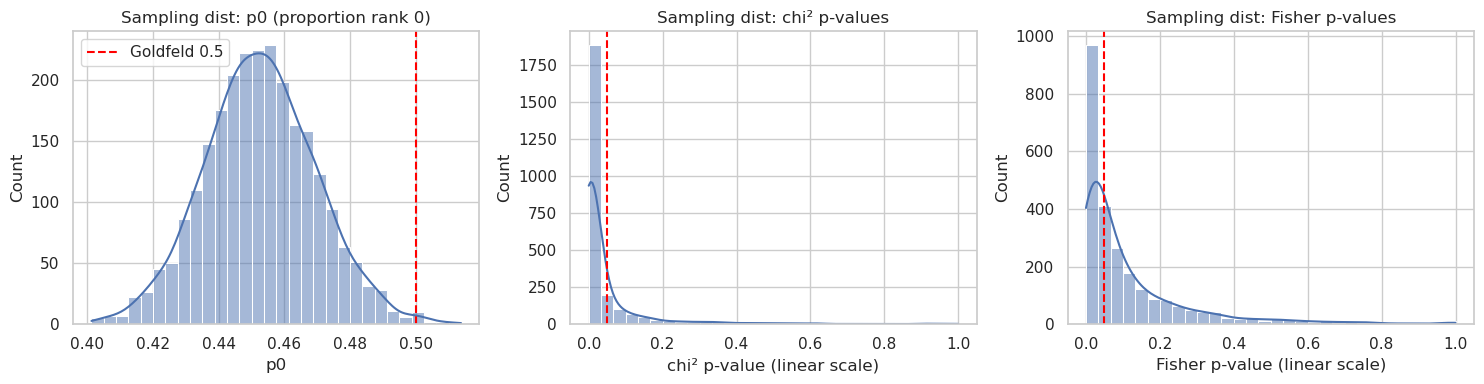

In [20]:
# Cell 5
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
sns.histplot(samples_df['p0'].dropna(), bins=30, kde=True)
plt.axvline(0.5, color='red', linestyle='--', label='Goldfeld 0.5')
plt.title("Sampling dist: p0 (proportion rank 0)")
plt.xlabel("p0")
plt.legend()
plt.savefig("p0dist.jpeg")

plt.subplot(1,3,2)
sns.histplot(samples_df['chi2_p'].dropna(), bins=30, kde=True)
plt.axvline(0.05, color='red', linestyle='--')
plt.title("Sampling dist: chi² p-values")
plt.xlabel("chi² p-value (linear scale)")

plt.subplot(1,3,3)
sns.histplot(samples_df['fisher_p'].dropna(), bins=30, kde=True)
plt.axvline(0.05, color='red', linestyle='--')
plt.title("Sampling dist: Fisher p-values")
plt.xlabel("Fisher p-value (linear scale)")

plt.tight_layout()
plt.show()


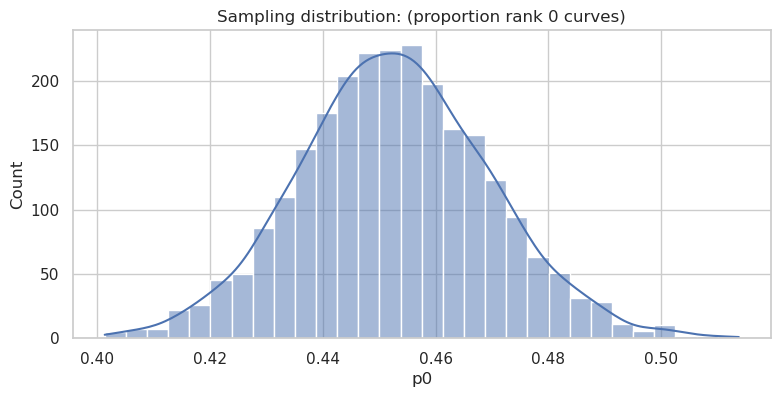

In [23]:
plt.figure(figsize=(9,4))
sns.histplot(samples_df['p0'].dropna(), bins=30, kde=True)
#plt.axvline(0.5, color='red', linestyle='--', label='Proportion 0.5')
plt.title("Sampling distribution: (proportion rank 0 curves)")
plt.xlabel("p0")
#plt.legend()
plt.savefig("p0dist.jpeg")

In [29]:
# Cell 6
alpha = 0.05
prop_significant_chi2 = (samples_df['chi2_p'] < alpha).mean()
prop_significant_fisher = (samples_df['fisher_p'] < alpha).mean()
mean_p0 = samples_df['p0'].mean()
std_p0 = samples_df['p0'].std()

print(f"p = {p}, reps = {reps}")
print(f"Expected sample size ≈ {N*p:.1f}; realized mean sample size = {samples_df['sample_size'].mean():.1f}")
print(f"Mean p0_hat = {mean_p0:.4f} (sd = {std_p0:.4f})")
print(f"Fraction of samples with chi² p < {alpha}: {prop_significant_chi2:.3f}")
print(f"Fraction of samples with fisher p < {alpha}: {prop_significant_fisher:.3f}")


p = 0.002, reps = 2000
Expected sample size ≈ 1215.9; realized mean sample size = 1216.1
Mean p0_hat = 0.4526 (sd = 0.0145)
Fraction of samples with chi² p < 0.05: 0.909
Fraction of samples with fisher p < 0.05: 0.677


In [30]:
# Cell 7
def windowed_bernoulli(df, p, window_max_list, reps=200, seed=10):
    rng = np.random.default_rng(seed)
    out = []
    for M in window_max_list:
        subset = df[df['n'] <= M]
        if len(subset) == 0:
            continue
        for i in range(reps):
            mask = bernoulli_sample_indices(len(subset), p, rng)
            sample = subset.loc[mask, 'an_rk_magma']
            c0, cge1, tot = two_bin_counts_from_series(sample)
            stats = run_tests_on_counts(c0, cge1)
            stats.update({'upto_n': M})
            out.append(stats)
    return pd.DataFrame(out)

windows = [50_000, 100_000, 200_000, 400_000, 600_000, 800_000, 1_000_000]
win_df = windowed_bernoulli(df, p=1/500, window_max_list=windows, reps=1000, seed=11)
win_summary = win_df.groupby('upto_n').agg(mean_p0=('p0','mean'),
                                           sd_p0=('p0','std'),
                                           mean_chi2_p=('chi2_p','mean'),
                                           mean_fisher_p=('fisher_p','mean'),
                                           reps=('p0','count')).reset_index()
win_summary


,upto_n,mean_p0,sd_p0,mean_chi2_p,mean_fisher_p,reps
0,50000,0.436575,0.064904,0.379171,0.598643,1000
1,100000,0.439609,0.046859,0.284534,0.468342,1000
2,200000,0.443550,0.033729,0.196263,0.340740,1000
3,400000,0.447763,0.023071,0.101588,0.203445,1000
4,600000,0.450688,0.018363,0.055167,0.134578,1000
5,800000,0.451121,0.016068,0.030148,0.085275,1000
6,1000000,0.452347,0.014078,0.018284,0.059422,1000


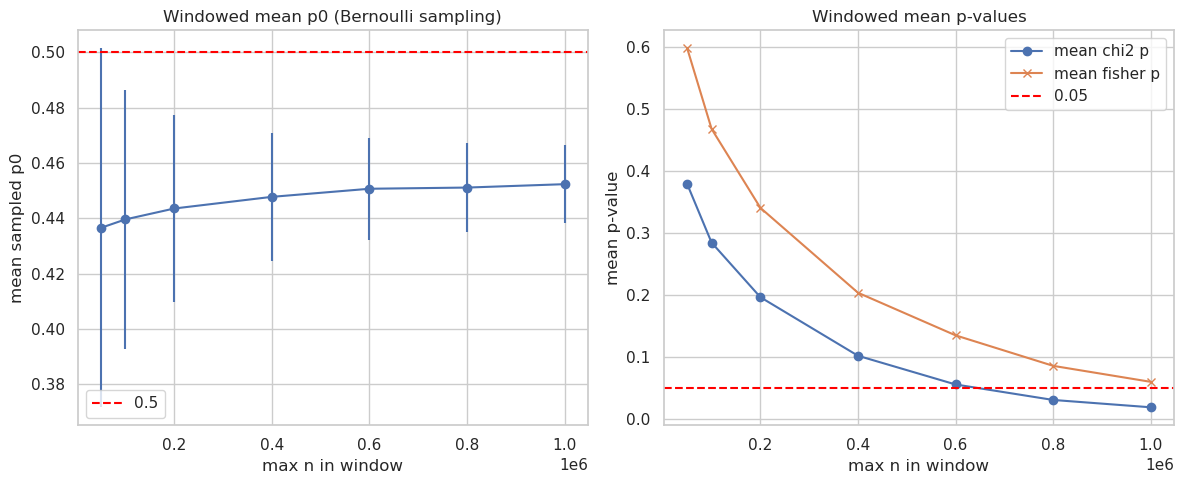

In [31]:
# Cell 8
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.errorbar(win_summary['upto_n'], win_summary['mean_p0'], yerr=win_summary['sd_p0'], marker='o')
plt.axhline(0.5, color='red', linestyle='--', label='0.5')
plt.xlabel('max n in window')
plt.ylabel('mean sampled p0')
plt.title('Windowed mean p0 (Bernoulli sampling)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(win_summary['upto_n'], win_summary['mean_chi2_p'], marker='o', label='mean chi2 p')
plt.plot(win_summary['upto_n'], win_summary['mean_fisher_p'], marker='x', label='mean fisher p')
plt.axhline(0.05, color='red', linestyle='--', label='0.05')
plt.xlabel('max n in window')
plt.ylabel('mean p-value')
plt.title('Windowed mean p-values')
plt.legend()

plt.tight_layout()
plt.show()


In [32]:
# Cell 9
samples_df.to_csv("bernoulli_sampling_results.csv", index=False)
win_summary.to_csv("windowed_bernoulli_summary.csv", index=False)
print("Saved results.")


Saved results.
